In [1]:
# 📚 Entrenamiento de Red Neuronal CNN para clasificación multiclase

# 🔧 Cargar librerías
import os
import sys
import yaml
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

2025-08-17 23:52:10.618671: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Ajustar path para importar módulos locales
sys.path.append("../src")
import model
import utils
import train

In [3]:
# 🔧 Cargar configuración
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

img_height = config["image"]["height"]
img_width = config["image"]["width"]
batch_size = config["training"]["batch_size"]
epochs = config["training"]["epochs"]
data_path = config["paths"]["prepared_data"]
model_path = config["paths"]["model"]

In [4]:
# 📦 Cargar datos
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, "train"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_path, "val"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 540 images belonging to 54 classes.
Found 355 images belonging to 54 classes.


In [5]:
# ✅ Verificar consistencia de clases
assert train_generator.class_indices == val_generator.class_indices
num_classes = len(train_generator.class_indices)

In [6]:
# 🧠 Construir modelo
cnn_model = model.build_model(config, num_classes)

cnn_model.summary()

/Users/sebazamorano/PycharmProjects/DeepNeuralNetworkUSS/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 54)             │         6,966 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,124,022 (8.10 MB)

 Trainable params: 2,123,830 (8.10 MB)

 Non-trainable params: 192 (768.00 B)

In [7]:
# 🏋️ Entrenar el modelo
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True)
]

history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks
)

/Users/sebazamorano/PycharmProjects/DeepNeuralNetworkUSS/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 299ms/step - accuracy: 0.0185 - loss: 5.4451 - val_accuracy: 0.0338 - val_loss: 3.9842
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.0352 - loss: 3.8717 - val_accuracy: 0.0225 - val_loss: 4.1204
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - accuracy: 0.0352 - loss: 3.8574 - val_accuracy: 0.0310 - val_loss: 7.9551
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.0556 - loss: 3.7832 - val_accuracy: 0.0282 - val_loss: 14.6236
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.0852 - loss: 3.6457 - val_accuracy: 0.0282 - val_loss: 19.0369
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 0.0926 - loss: 3.5872 - val_accuracy: 0.0282 - val_loss: 22.7705


In [8]:
# 💾 Guardar modelo
cnn_model.save(model_path)

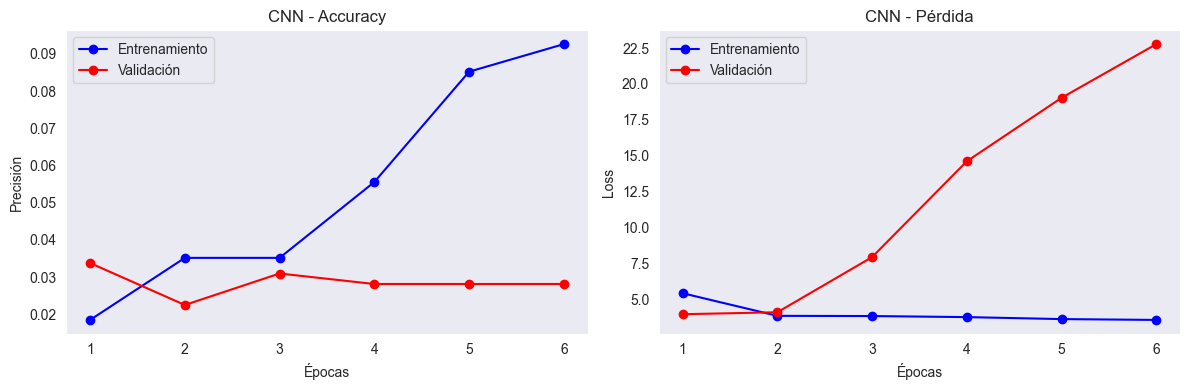

In [9]:
# 📈 Graficar historia de entrenamiento
utils.plot_training_history(history, model_name="CNN")

In [10]:
# ✅ Guardar nombres de clases para uso posterior
with open("class_indices.yaml", "w") as f:
    yaml.dump(train_generator.class_indices, f)